In [1]:
import pandas as pd
import numpy as np

import nltk
from nltk.tokenize import word_tokenize
import unicodedata

import re
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from pysentimiento import create_analyzer

tqdm.pandas()

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Descargar paquete de la librería NLTK

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dani\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Definición de funciones

In [4]:
def preprocessing_text(text):
    #Quitar caracteres especiales del texto
    text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('utf-8')
    
    # Reemplazar dobles espacios con espacios simples
    text = re.sub(r'\s+', ' ', text)

    # Tokenizer el texto usando el tokenizador de NLTK
    tokens = word_tokenize(text)

    return ' '.join(tokens)

def mention_in_tweet(text, ptt):
    #Funcion para saber si Davivienda fue mencionado en el tweet
    return text.lower().count(ptt.lower())

def get_sentiment_analysis(model, text):
    #Extracción del analisis de sentimientos
    prediction = model.predict(text)
    if prediction.output == 'POS':
        return 'Positivo', prediction.probas[prediction.output]
    elif prediction.output == 'NEG':
        return 'Negativo', -prediction.probas[prediction.output]
    elif prediction.output == 'NEU':
        return 'Neutro', 0

## Carga de la información

In [5]:
df_tweets = pd.read_csv('davivienda_tweets.csv')
df_tweets.drop('Unnamed: 0', inplace=True, axis=1)

## Preprocesamiento del texto y extracción de las menciones a Davivienda por Tweet

In [7]:
df_tweets['clean_text'] = df_tweets['Embedded_text'].apply(preprocessing_text)
df_tweets['mention_davivienda'] = df_tweets['clean_text'].apply(lambda x: mention_in_tweet(x, 'Davivienda'))
df_tweets['Timestamp'] = pd.to_datetime(df_tweets['Timestamp'])

df_tweets = df_tweets[['UserName', 'Timestamp', 'clean_text', 'mention_davivienda']]

## Distribución del conteo de las menciones de Davivienda en los diferentes Tweets

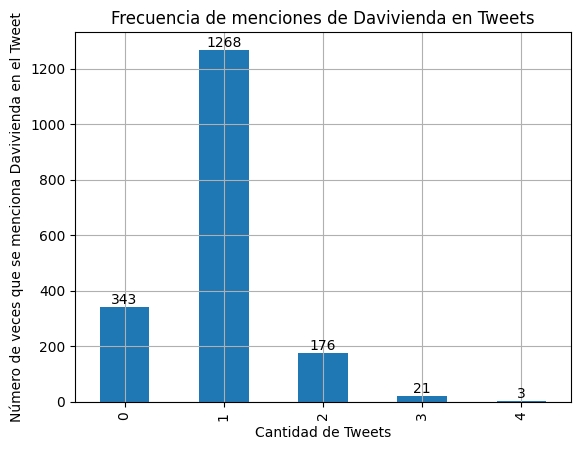

In [78]:
plot_freq_mentions = df_tweets['mention_davivienda'].value_counts().sort_index()

ax = plot_freq_mentions.plot(kind='bar')

# Set labels and title
plt.xlabel('Cantidad de Tweets')
plt.ylabel('Número de veces que se menciona Davivienda en el Tweet')
plt.title('Frecuencia de menciones de Davivienda en Tweets')
plt.grid()

# Annotate bars with their respective values
for i, v in enumerate(plot_freq_mentions):
    ax.text(i, v, str(v), ha='center', va='bottom')

# Show the plot
plt.show()

## Eliminación de los tweets que no mencionan a Davivienda

In [79]:
df_tweets = df_tweets[df_tweets['mention_davivienda'] > 0]

## Análisis de Sentimientos

In [80]:
sent_anal_model = create_analyzer(task="sentiment", lang="es")

In [81]:
df_tweets[['sentiment','sentiment_value']]  = df_tweets['clean_text'].progress_apply(lambda x: pd.Series(get_sentiment_analysis(sent_anal_model, x)))

100%|██████████| 1468/1468 [00:34<00:00, 42.82it/s]


Calculo del sentiment value, usando el valor del sentimiento y la cantidad de veces que mencionan a Davivienda.

In [82]:
df_tweets['sentiment_value'] = df_tweets['sentiment_value']*df_tweets['mention_davivienda']

## Distribución de tweets por cada sentimiento

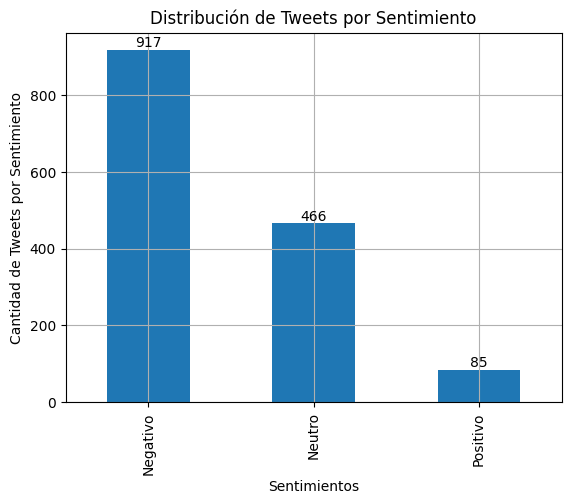

In [83]:
sent_plot = df_tweets['sentiment'].value_counts()
ax = sent_plot.plot(kind='bar')

# Set labels and title
plt.xlabel('Sentimientos')
plt.ylabel('Cantidad de Tweets por Sentimiento')
plt.title('Distribución de Tweets por Sentimiento')
plt.grid()

# Annotate bars with their respective values
for i, v in enumerate(sent_plot):
    ax.text(i, v, str(v), ha='center', va='bottom')

# Show the plot
plt.show()

## Distribuciónde Tweets por usuarios

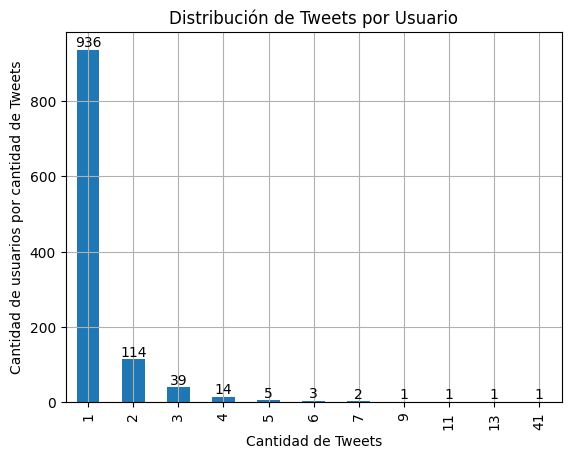

In [84]:
plot_cant_tweets_user = df_tweets['UserName'].value_counts().reset_index()['UserName'].value_counts().sort_index()

ax = plot_cant_tweets_user.plot(kind='bar')

# Set labels and title
plt.xlabel('Cantidad de Tweets')
plt.ylabel('Cantidad de usuarios por cantidad de Tweets')
plt.title('Distribución de Tweets por Usuario')
plt.grid()

# Annotate bars with their respective values
for i, v in enumerate(plot_cant_tweets_user):
    ax.text(i, v, str(v), ha='center', va='bottom')

# Show the plot
plt.show()

## Cantidad de tweets por fecha

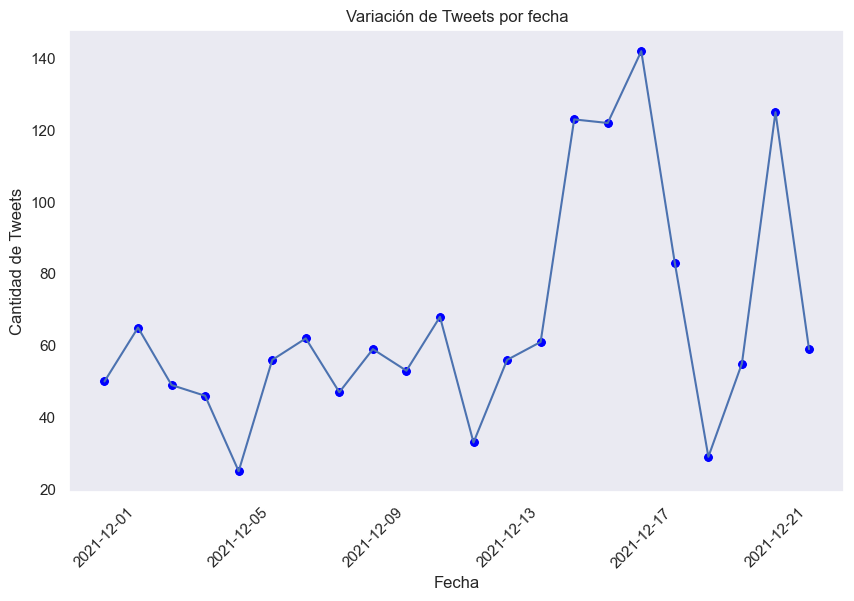

In [132]:
df_dates = df_tweets['Timestamp'].dt.normalize().value_counts().sort_index().reset_index()

# Plot the date vs. number
sns.lineplot(x="index", y="Timestamp", data=df_dates)
sns.scatterplot(x="index", y="Timestamp", data=df_dates, color='blue', s=50)


# Set x-axis label and title
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Tweets')
plt.title('Variación de Tweets por fecha')

# Rotate x-axis date labels for better visibility
plt.xticks(rotation=45)
plt.grid()

# Show the plot
plt.show()

## Conteo de usuarios detractores, promotores y neutros para cada fecha

In [106]:
fechas = df_tweets['Timestamp'].dt.normalize().drop_duplicates().sort_values()
data = []

for fecha in fechas:
    df_tweets_tmp = df_tweets[df_tweets['Timestamp'].dt.normalize()==fecha]
    df_users = df_tweets_tmp[['UserName', 'sentiment_value']].groupby('UserName').sum().reset_index()
    detractores = len(df_users[df_users['sentiment_value']<0])
    promotores = len(df_users[df_users['sentiment_value']>0])
    neutros = len(df_users[df_users['sentiment_value']==0])
    data.append([fecha, promotores, detractores, neutros])

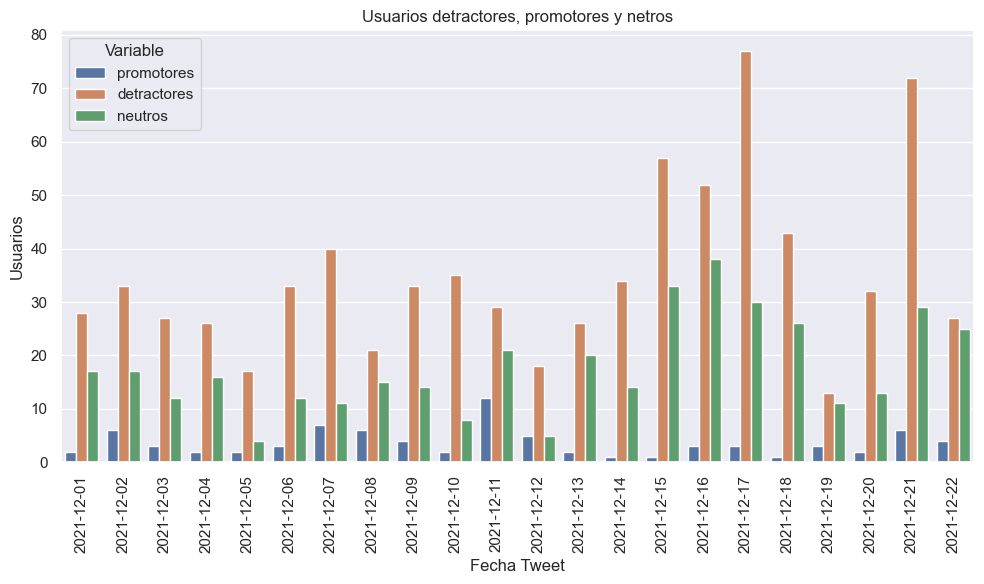

In [126]:
# Melt the DataFrame to convert variables into a single column
df = pd.DataFrame(data, columns=['fecha', 'promotores', 'detractores', 'neutros'])
df['fecha'] = df['fecha'].astype(str).str[:10]
df_melted = df.melt(id_vars='fecha', var_name='Variable', value_name='Value')

# Set the figure size using seaborn style (optional)
sns.set(rc={'figure.figsize': (10, 6)})

# Create the bar plot using seaborn
sns.barplot(data=df_melted, x='fecha', y='Value', hue='Variable')

# Set labels and title
plt.xlabel('Fecha Tweet')
plt.ylabel('Usuarios')
plt.title('Usuarios detractores, promotores y netros')

plt.xticks(rotation=90)

# Show the plot
plt.tight_layout()
plt.show()